In [1]:
import sys
import platform

try:
    import tweedledum
    print("Tweedledum library is installed.")
except ImportError:
    if platform.system() == 'Darwin':
        print("Tweedledum library is not installed and your system (MacOS) is not compatible with this program.")
    else:
        print("Tweedledum library is not installed.")

Tweedledum library is installed.


# Nonogram Code

In [18]:
import numpy as np
# All possible nonogram descriptions for l=5 through l=5
# TODO: Replace with function to generate all bitstrings for a given clue

possible_d = {
    # l = 1
    "1/0;" : [0b0],
    "1/1;" : [0b1],
        
    # l = 2
    "2/0;" : [0b00],
    "2/1;" : [0b01,0b10],
    "2/2;" : [0b11],
    
    # l = 3
    "3/0;" : [0b000],
    "3/1;" : [0b100, 0b010,0b001],
    "3/2;" : [0b110,0b011],
    "3/3;" : [0b111],
    "3/1;1;" : [0b101],
    
    # l = 4
    "4/0;" : [0b0000],
    "4/1;" : [0b1000,0b0100, 0b0010,0b0001],
    "4/2;" : [0b1100,0b0110,0b0011],
    "4/3;" : [0b1110,0b0111],
    "4/4;" : [0b1111],
    "4/1;1;" : [0b1010,0b0101,0b1001],
    "4/2;1;" : [0b1101],
    "4/1;2;" : [0b1011],
              
    # l = 5
    "5/0;" : [0b00000],
    "5/1;" : [0b10000,0b01000,0b00100,0b00010,0b00001],
    "5/2;" : [0b11000,0b01100,0b00110, 0b00011],
    "5/3;" : [0b11100,0b01110,0b00111],
    "5/4;" : [0b11110,0b01111],
    "5/5;" : [0b11111],
    "5/1;1;" : [0b10100,0b10010,0b10001,0b01010,0b01001,0b00101],
    "5/1;2;" : [0b10011,0b10110,0b01011],
    "5/1;3;" : [0b10111],
    "5/2;1;" : [0b11001,0b11010,0b01101,],
    "5/2;2;" : [0b11011],
    "5/3;1;" : [0b11101],
    "5/1;1;1;" : [0b10101],

    # l = 6
    "6/0;" : [0b000000],
    "6/1;" : [0b100000, 0b010000, 0b001000, 0b000100, 0b000010, 0b000001],
    "6/2;" : [0b110000, 0b011000, 0b001100, 0b000110, 0b000011],
    "6/3;" : [0b111000, 0b011100, 0b001110, 0b000111],
    "6/4;" : [0b111100, 0b011110, 0b001111],
    "6/5;" : [0b111110, 0b011111],
    "6/6;" : [0b111111],
    "6/1;1;" : [0b101000, 0b100100, 0b100010, 0b100001, 0b010100, 0b010010, 0b010001, 0b001010, 0b001001, 0b000101],
    "6/1;2;" : [0b101100, 0b100110, 0b100011, 0b010110, 0b010011, 0b001011],
    "6/1;3;" : [0b101110, 0b100111, 0b010111],
    "6/1;4;" : [0b101111],
    "6/2;1;" : [0b110100, 0b110010, 0b110001, 0b011010, 0b011001, 0b001101],
    "6/2;2;" : [0b110110, 0b110011, 0b011011],
    "6/2;3;" : [0b110111],
    "6/3;1;" : [0b111010, 0b111001, 0b011101],
    "6/3;2;" : [0b111011],
    "6/4;1;" : [0b111101],
    "6/1;1;1;" : [0b101010, 0b101001, 0b100101, 0b010101],
    "6/1;1;2;" : [0b101011],
    "6/1;2;1;" : [0b101101],
    "6/2;1;1;" : [0b110101],
}



# Takes an n x d board and returns the variables for each row, column
def var_clauses(n, d=None):
    if d is None:
        d = n
    X = np.arange(n*d).reshape((n,d))
    col_vars = []
    row_vars = []
    for row in range(n):
        row_vars.append(list(X[row, :]))
    for col in range(d):
        col_vars.append(list(X[:, col]))
    return row_vars, col_vars

# TODO: move out magic
def display_nonogram(bit_string, n, d):
    if (n*d > len(bit_string)):
        raise Exception(f'bitstring is length {len(bit_string)}, expected {n * d}')
    
    puzzle_array = np.zeros((n ,d))
    for i in range(n):
        for j in range(d):
            puzzle_array[i,j] = int(bit_string[i*d+j])
    print('╔' + '═'*d + '╗')
    
    for i in range(n):
        print_row = '║'
        for j in range(d):
            if puzzle_array[i,j] == 0:
                print_row += '□'
            else:
                print_row += '■'
        print_row += '║ ' 
        print(print_row)
    print('╚' + '═'*d + '╝')
    
def validate(rows, cols, r_clues, c_clues):
    if (len(r_clues) != rows):
        raise Exception(f"Error: Number of clues {len(r_clues)} invalid to row size {rows}")
    if (len(c_clues) != cols):
        raise Exception(f"Error: Number of clues {len(c_clues)} invalid to row size {cols}")
    # TODO: Flesh out clue validation with invalid clue for given length/width
    return True

def puzzle_to_boolean(row_clues, col_clues, classical = False):
    # TODO: this function doesn't work as intended for clues like 2;1; because it reverses the order to become 1;2;
    AND = "&"
    OR = "|"
    VARIABLE = "v"
    NOT = "~"
    END = ";"
    
    n = len(row_clues)
    d = len(col_clues)

    boolean_statement = ""
    classical_statement = []
    r_v, c_v = var_clauses(n, d)
    
    for r_idx, r_clue in enumerate(row_clues):
        bitstrings = possible_d[f"{d}/{END.join(map(str, r_clue))}{END}"]
        clauses = []
        classical_clauses = []
        for b_idx, bitstring in enumerate(bitstrings):
            clause = ""
            classical_clause = []
            for c_idx in range(d):
                clause += f'{"" if bitstring & (1 << c_idx) else NOT}{VARIABLE}{r_v[r_idx][c_idx]}{AND}'
                classical_clause.append((-1 if bitstring & (1 << c_idx) else 1) * (1 + r_v[r_idx][c_idx]))
            clauses.append(f"({clause[:-1]})")
            classical_clauses.append(classical_clause)
        boolean_statement += f"({OR.join(clauses)}){AND}"
        classical_statement.append(classical_clauses)
        
 # iterate over column clues (same as with row clues, but with transposed variables)
    for c_idx, c_clue in enumerate(col_clues):
        bitstrings = possible_d[f"{n}/{';'.join(map(str, c_clue))};"]
        clauses = []
        classical_clauses = []
        for b_idx, bitstring in enumerate(bitstrings):
            clause = ""
            classical_clause = []
            for r_idx in range(n):
                clause += f"{'' if bitstring & (1 << r_idx) else NOT}{VARIABLE}{r_v[r_idx][c_idx]}{AND}"
                classical_clause.append((-1 if bitstring & (1 << r_idx) else 1) * (1 + r_v[r_idx][c_idx]))
            clauses.append(f"({clause[:-1]})")
            classical_clauses.append(classical_clause)
        boolean_statement += f"({OR.join(clauses)}){AND}"
        classical_statement.append(classical_clauses)
 
    # remove trailing "&"
    return boolean_statement[:-1] if not classical else (classical_statement, n*d)

# Initialization Code

In [19]:
# Define nonogram [size and clues]
solutions = ["100001110011101101100001"]
if not solutions or len(solutions) == 1:
    num_solutions = 1 # Assumed
else:
    num_solutions = len(solutions) # Given

# Make sure all rows/cols have a clue, even if 0
row_clues = [(1,1,),(2,2),(1,2,1),(1,1,)]
col_clues = [(4,),(1,),(1,),(1,),(1,),(4,)]

puzzle = (row_clues, col_clues)

# Solvers

In [4]:
import cProfile, pstats, io
from pstats import SortKey

## Classical

In [5]:
def classical_solve(puzzle, manual_check=None):
    expression, var_num = puzzle_to_boolean(row_clues=puzzle[0], col_clues=puzzle[1], classical=True)
    print(f"Solving {expression}")
    
    search_space = (manual_check,) if manual_check is not None else range(2**var_num) 
    solutions = []
    for solution in search_space:
        configuration = manual_check if manual_check is not None else bin(solution)[2:].zfill(var_num)[::-1]
        expression_value = True
        for clause in expression:
            clause_value = False
            if manual_check is not None:
                print(f"Clause:{clause}")
            for subclause in clause:
                subclause_value = True
                if manual_check is not None:
                    print(f"Subclause:{subclause}")
                for literal in subclause:
                    index = literal if literal > 0 else -1*literal
                    config_value = configuration[index - 1: index]
                    truth_value = config_value == '0'
                    negated = literal < 0
                    literal_value = not truth_value if negated else truth_value
                    subclause_value &= literal_value
                    if manual_check is not None:
                        print(literal, index, config_value, truth_value, negated, literal_value, subclause_value)
                clause_value |= subclause_value
                if manual_check is not None:
                    print(f"Clause value:{clause_value}")
            expression_value &= clause_value
            if manual_check is not None:
                print(f"Expression value:{expression_value}")
        if expression_value == True:
            solutions.append(configuration)
    return solutions

In [20]:
pr = cProfile.Profile()
pr.enable()

try:
    classical_results = classical_solve(puzzle)
except Exception as ex:
    print(ex)

pr.disable()

Solving [[[1, 2, 3, -4, 5, -6], [1, 2, -3, 4, 5, -6], [1, -2, 3, 4, 5, -6], [-1, 2, 3, 4, 5, -6], [1, 2, -3, 4, -5, 6], [1, -2, 3, 4, -5, 6], [-1, 2, 3, 4, -5, 6], [1, -2, 3, -4, 5, 6], [-1, 2, 3, -4, 5, 6], [-1, 2, -3, 4, 5, 6]], [[7, -8, -9, 10, -11, -12], [-7, -8, 9, 10, -11, -12], [-7, -8, 9, -10, -11, 12]], [[-13, 14, -15, -16, 17, -18]], [[19, 20, 21, -22, 23, -24], [19, 20, -21, 22, 23, -24], [19, -20, 21, 22, 23, -24], [-19, 20, 21, 22, 23, -24], [19, 20, -21, 22, -23, 24], [19, -20, 21, 22, -23, 24], [-19, 20, 21, 22, -23, 24], [19, -20, 21, -22, 23, 24], [-19, 20, 21, -22, 23, 24], [-19, 20, -21, 22, 23, 24]], [[-1, -7, -13, -19]], [[2, 8, 14, -20], [2, 8, -14, 20], [2, -8, 14, 20], [-2, 8, 14, 20]], [[3, 9, 15, -21], [3, 9, -15, 21], [3, -9, 15, 21], [-3, 9, 15, 21]], [[4, 10, 16, -22], [4, 10, -16, 22], [4, -10, 16, 22], [-4, 10, 16, 22]], [[5, 11, 17, -23], [5, 11, -17, 23], [5, -11, 17, 23], [-5, 11, 17, 23]], [[-6, -12, -18, -24]]]


### Profile

In [21]:
s = io.StringIO()
sortby = SortKey.CUMULATIVE
ps = pstats.Stats(pr, stream=s).sort_stats(sortby)
ps.print_stats()
print(s.getvalue())

         33554853 function calls in 1072.733 seconds

   Ordered by: cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        2    0.000    0.000 1072.733  536.367 /home/acpeters/miniconda3/envs/py38/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3472(run_code)
        2    0.000    0.000 1072.733  536.367 {built-in method builtins.exec}
        1    0.000    0.000 1072.733 1072.733 /tmp/ipykernel_735/2263297468.py:4(<module>)
        1 1069.443 1069.443 1072.733 1072.733 /tmp/ipykernel_735/572905131.py:1(classical_solve)
 16777216    2.011    0.000    2.011    0.000 {built-in method builtins.bin}
 16777216    1.278    0.000    1.278    0.000 {method 'zfill' of 'str' objects}
        1    0.000    0.000    0.000    0.000 /tmp/ipykernel_735/2866717568.py:116(puzzle_to_boolean)
        1    0.000    0.000    0.000    0.000 {built-in method builtins.print}
        2    0.000    0.000    0.000    0.000 /home/acpeters/miniconda3/envs/py3

### Results

In [22]:
print("Expected: ")
for solution in solutions:
    print(solution)
    display_nonogram(solution, len(puzzle[0]), len(puzzle[1]))
    
print("Actual: ")
for solution in classical_results:
    print(solution)
    display_nonogram(solution, len(puzzle[0]), len(puzzle[1]))

Expected: 
100001110011101101100001
╔══════╗
║■□□□□■║ 
║■■□□■■║ 
║■□■■□■║ 
║■□□□□■║ 
╚══════╝
Actual: 
100001110011101101100001
╔══════╗
║■□□□□■║ 
║■■□□■■║ 
║■□■■□■║ 
║■□□□□■║ 
╚══════╝


## Quantum

In [12]:
from qiskit.circuit.library import PhaseOracle
from qiskit_algorithms import AmplificationProblem
from qiskit.primitives import Sampler
from qiskit_algorithms import Grover

def quantum_solve(puzzle):
    expression = puzzle_to_boolean(row_clues=puzzle[0],col_clues=puzzle[1])
    print(f"Solving {expression}")
    oracle = PhaseOracle(expression)
    problem = AmplificationProblem(oracle, is_good_state=oracle.evaluate_bitstring)
    grover = Grover(sampler=Sampler())
    result = grover.amplify(problem)
    return result

In [23]:
pr = cProfile.Profile()
pr.enable()

try:
    quantum_results = quantum_solve(puzzle)
except Exception as ex:
    print(ex)

pr.disable()

Solving ((~v0&~v1&~v2&v3&~v4&v5)|(~v0&~v1&v2&~v3&~v4&v5)|(~v0&v1&~v2&~v3&~v4&v5)|(v0&~v1&~v2&~v3&~v4&v5)|(~v0&~v1&v2&~v3&v4&~v5)|(~v0&v1&~v2&~v3&v4&~v5)|(v0&~v1&~v2&~v3&v4&~v5)|(~v0&v1&~v2&v3&~v4&~v5)|(v0&~v1&~v2&v3&~v4&~v5)|(v0&~v1&v2&~v3&~v4&~v5))&((~v6&v7&v8&~v9&v10&v11)|(v6&v7&~v8&~v9&v10&v11)|(v6&v7&~v8&v9&v10&~v11))&((v12&~v13&v14&v15&~v16&v17))&((~v18&~v19&~v20&v21&~v22&v23)|(~v18&~v19&v20&~v21&~v22&v23)|(~v18&v19&~v20&~v21&~v22&v23)|(v18&~v19&~v20&~v21&~v22&v23)|(~v18&~v19&v20&~v21&v22&~v23)|(~v18&v19&~v20&~v21&v22&~v23)|(v18&~v19&~v20&~v21&v22&~v23)|(~v18&v19&~v20&v21&~v22&~v23)|(v18&~v19&~v20&v21&~v22&~v23)|(v18&~v19&v20&~v21&~v22&~v23))&((v0&v6&v12&v18))&((~v1&~v7&~v13&v19)|(~v1&~v7&v13&~v19)|(~v1&v7&~v13&~v19)|(v1&~v7&~v13&~v19))&((~v2&~v8&~v14&v20)|(~v2&~v8&v14&~v20)|(~v2&v8&~v14&~v20)|(v2&~v8&~v14&~v20))&((~v3&~v9&~v15&v21)|(~v3&~v9&v15&~v21)|(~v3&v9&~v15&~v21)|(v3&~v9&~v15&~v21))&((~v4&~v10&~v16&v22)|(~v4&~v10&v16&~v22)|(~v4&v10&~v16&~v22)|(v4&~v10&~v16&~v22))&((v5&v11&v

/tmp/ipykernel_735/3871354082.py:11: DeprecationWarning: The class ``qiskit.primitives.sampler.Sampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Sampler` class is `StatevectorSampler`.
  grover = Grover(sampler=Sampler())


### Profile

In [24]:
s = io.StringIO()
sortby = SortKey.CUMULATIVE  
ps = pstats.Stats(pr, stream=s).sort_stats(sortby)
ps.print_stats()
print(s.getvalue())

         336908543 function calls (336899321 primitive calls) in 48825.601 seconds

   Ordered by: cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        2    0.000    0.000 48825.601 24412.800 /home/acpeters/miniconda3/envs/py38/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3472(run_code)
        2    0.000    0.000 48825.601 24412.800 {built-in method builtins.exec}
        1    0.019    0.019 48825.601 48825.601 /tmp/ipykernel_735/243519299.py:4(<module>)
        1    0.239    0.239 48825.581 48825.581 /tmp/ipykernel_735/3871354082.py:6(quantum_solve)
      2/1    0.000    0.000 43694.345 43694.345 /home/acpeters/miniconda3/envs/py38/lib/python3.8/site-packages/qiskit/utils/classtools.py:108(out)
        1    0.000    0.000 43694.345 43694.345 /home/acpeters/miniconda3/envs/py38/lib/python3.8/site-packages/qiskit/circuit/library/phase_oracle.py:51(__init__)
        1    0.000    0.000 43694.342 43694.342 /home/acpeters/minicon

### Results

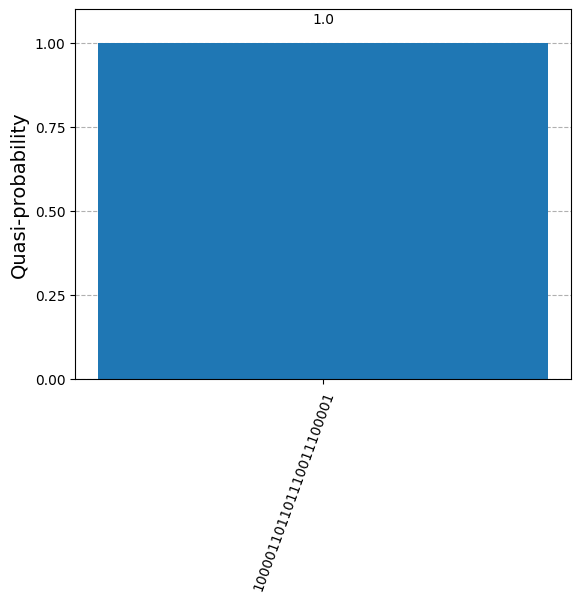

In [25]:
from qiskit.visualization import plot_histogram
from operator import itemgetter

data = dict(sorted(quantum_results.circuit_results[0].items(), key=itemgetter(1), reverse=True)[:num_solutions])
display(plot_histogram(data))

In [26]:
print("Expected: ")
for solution in solutions:
    print(solution)
    display_nonogram(solution, len(puzzle[0]), len(puzzle[1]))
    
print("Actual: ")
for solution in data:
    print(solution[::-1])
    display_nonogram(solution[::-1], len(puzzle[0]), len(puzzle[1]))

Expected: 
100001110011101101100001
╔══════╗
║■□□□□■║ 
║■■□□■■║ 
║■□■■□■║ 
║■□□□□■║ 
╚══════╝
Actual: 
100001110011101101100001
╔══════╗
║■□□□□■║ 
║■■□□■■║ 
║■□■■□■║ 
║■□□□□■║ 
╚══════╝
